# MLP

In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


Preprocessing

In [2]:

def preprocess_data_with_target(df, target):
    df = df.copy()
    # Drop index columns if present
    for col in df.columns:
        if 'unnamed' in col.lower():
            df = df.drop(columns=[col])
    # Fill missing values
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]
    encoders = {}
    # One-hot encode categorical variables
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
        X_cat = ohe.fit_transform(X[cat_cols])
        ohe_cols = ohe.get_feature_names_out(cat_cols)
        X_cat_df = pd.DataFrame(X_cat, columns=ohe_cols, index=X.index)
        X = X.drop(columns=cat_cols)
        X = pd.concat([X, X_cat_df], axis=1)
        encoders['onehot'] = ohe
    else:
        encoders['onehot'] = None
    # Label encode target if needed
    if y.dtype == object or str(y.dtype) == 'category':
        le = LabelEncoder()
        y = le.fit_transform(y)
        encoders['target'] = le
    # Standardize numeric columns
    scaler = StandardScaler()
    num_cols = X.select_dtypes(include=[np.int64, np.float64]).columns
    X[num_cols] = scaler.fit_transform(X[num_cols])
    return X, y, encoders, scaler


In [3]:
# Load data and preprocess
train_df = pd.read_csv("project_adult.csv")
X, y, encoders, scaler = preprocess_data_with_target(train_df, target="income")

In [4]:
def preprocess_data_no_target(df, encoders, scaler):
    df = df.copy()
    # Drop index columns if present
    for col in df.columns:
        if 'unnamed' in col.lower():
            df = df.drop(columns=[col])
    # Fill missing values
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    # One-hot encode categorical with previous encoder
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if encoders['onehot'] is not None and len(cat_cols) > 0:
        X_cat = encoders['onehot'].transform(df[cat_cols])
        ohe_cols = encoders['onehot'].get_feature_names_out(cat_cols)
        X_cat_df = pd.DataFrame(X_cat, columns=ohe_cols, index=df.index)
        df = df.drop(columns=cat_cols)
        df = pd.concat([df, X_cat_df], axis=1)
    # Standardize numeric columns with previous scaler
    num_cols = df.select_dtypes(include=[np.int64, np.float64]).columns
    df[num_cols] = scaler.transform(df[num_cols])
    return df


In [5]:
val_df = pd.read_csv("project_validation_inputs.csv")
X_val = preprocess_data_no_target(val_df, encoders, scaler)

Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42, stratify=y
)

Define PyTorch MLP block with activation

In [7]:
class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=2, num_hidden_layers=1, dropout=0.0, activation='relu'):
        super().__init__()
        activ_map = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
        }
        activ_func = activ_map[activation]
        layers = [nn.Linear(input_dim, hidden_dim), activ_func()]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), activ_func()]
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
    def forward(self, X):
        return self.network(X)

skorch neural net/block for grid search

In [8]:
net = NeuralNetClassifier(
    MLPModule,
    max_epochs=10,
    lr=0.01,
    module__input_dim=X_train.shape[1],
    module__output_dim=len(np.unique(y)),
    iterator_train__shuffle=True,
    verbose=0,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

param_grid = {
    'lr': [0.01, 0.001],
    'max_epochs': [30, 50],
    'module__hidden_dim': [16, 32],
    'module__num_hidden_layers': [1, 2],
    'module__dropout': [0.0, 0.25],
    'optimizer': [torch.optim.Adam, torch.optim.SGD],
    'module__activation': ['relu', 'tanh', 'sigmoid'],
    'criterion': [nn.CrossEntropyLoss, nn.NLLLoss],
    'batch_size': [32, 64]
}

Grid Search

In [9]:
gs = GridSearchCV(net, param_grid, refit=True, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
gs.fit(X_train.astype(np.float32), y_train.astype(np.longlong))

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
[CV 3/3] END batch_size=32, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.01, max_epochs=30, module__activation=relu, module__dropout=0.0, module__hidden_dim=16, module__num_hidden_layers=1, optimizer=<class 'torch.optim.sgd.SGD'>;, score=0.846 total time=   6.4s
[CV 1/3] END batch_size=32, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.01, max_epochs=30, module__activation=relu, module__dropout=0.0, module__hidden_dim=16, module__num_hidden_layers=1, optimizer=<class 'torch.optim.sgd.SGD'>;, score=0.851 total time=   6.5s
[CV 2/3] END batch_size=32, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.01, max_epochs=30, module__activation=relu, module__dropout=0.0, module__hidden_dim=16, module__num_hidden_layers=1, optimizer=<class 'torch.optim.sgd.SGD'>;, score=0.852 total time=   6.5s
[CV 1/3] END batch_size=32, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>,

GridSearchCV(cv=3,
             estimator=NeuralNetClassifier(_params_to_validate={'iterator_train__shuffle', 'module__output_dim', 'module__input_dim'}, batch_size=128, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cpu', iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_train__shuffle=True, iterator_valid=<class 'to...
                         'criterion': [<class 'torch.nn.modules.loss.CrossEntropyLoss'>,
                                       <class 'torch.nn.modules.loss.NLLLoss'>],
                         'lr': [0.01, 0.001], 'max_epochs': [30, 50],
                         'module__activation': ['relu', 'tanh', 'sigmoid'],
                         'module__dropout': [0.0, 0.25],
                         'module__hidden_dim': [16, 32],
                         'module__num_hidden_layers': [1, 2],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.sgd.SGD'>]},
             scoring='accuracy', verbose=3)

Evaluate and Visualize Best Model

🏆 Best Hyperparameters:
  batch_size: 32
  criterion: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
  lr: 0.001
  max_epochs: 30
  module__activation: sigmoid
  module__dropout: 0.0
  module__hidden_dim: 16
  module__num_hidden_layers: 2
  optimizer: <class 'torch.optim.adam.Adam'>

✅ Test Accuracy: 0.846

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3956
           1       0.70      0.63      0.66      1254

    accuracy                           0.85      5210
   macro avg       0.79      0.77      0.78      5210
weighted avg       0.84      0.85      0.84      5210



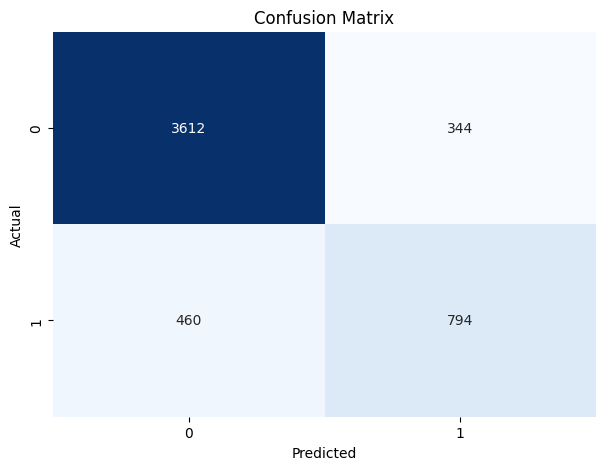

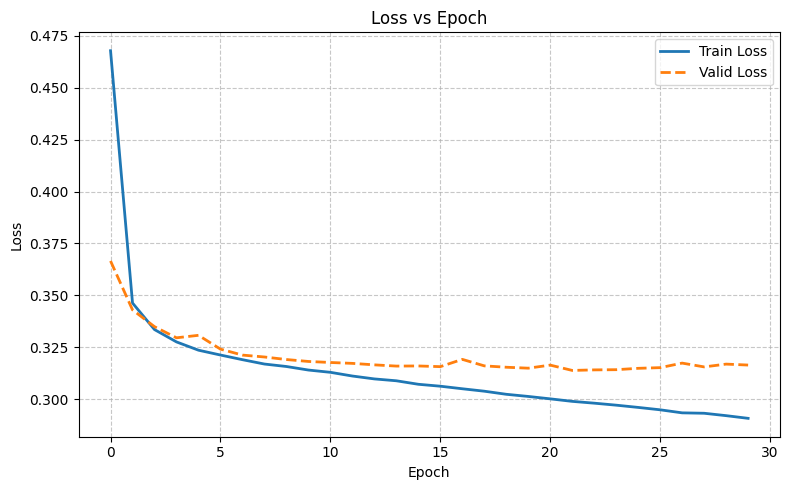

In [10]:
import seaborn as sns

best_net = gs.best_estimator_

print("="*50)
print("🏆 Best Hyperparameters:")
for key, value in gs.best_params_.items():
    print(f"  {key}: {value}")
print("="*50)

y_pred = best_net.predict(X_test.astype(np.float32))
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.3f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Training history (loss and accuracy)
history = best_net.history

plt.figure(figsize=(8,5))

if 'train_acc' in history[0] and 'valid_acc' in history[0]:
    # Plot Accuracy
    plt.plot(history[:, 'train_acc'], label='Train Accuracy', linewidth=2)
    plt.plot(history[:, 'valid_acc'], label='Validation Accuracy', linewidth=2, linestyle='--')
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
else:
    # Plot Loss if accuracy not present
    plt.plot(history[:, 'train_loss'], label='Train Loss', linewidth=2)
    plt.plot(history[:, 'valid_loss'], label='Valid Loss', linewidth=2, linestyle='--')
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Predict and Export Validation Outputs

In [11]:
val_preds = best_net.predict(X_val.values.astype(np.float32))

# Decode if needed
if 'target' in encoders:
    val_preds_decoded = encoders['target'].inverse_transform(val_preds)
else:
    val_preds_decoded = val_preds

y_val_final = np.where(val_preds_decoded == '>50K', 1, -1)
pd.DataFrame({'Predicted': y_val_final}).to_csv('Group_23_MLP_PredictedOutputs.csv', index=False)
print("Validation outputs saved as Group_23_MLP_PredictedOutputs.csv")

Validation outputs saved as Group_23_MLP_PredictedOutputs.csv
